In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Optimal Parameters:
a=0.1290, b=0.0591, sigma=0.0470, r0=0.0343


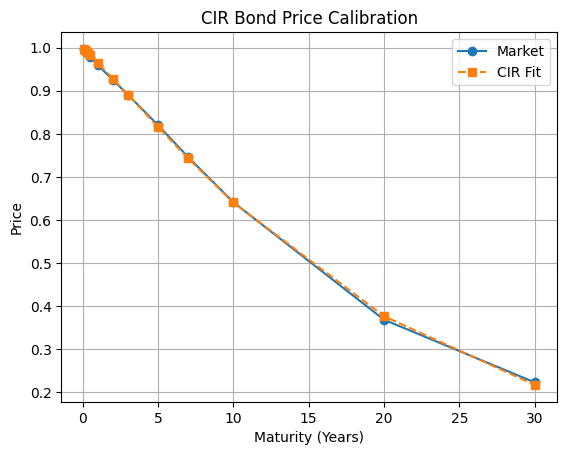

RMSE: 0.003847


In [2]:
%run CIR_Calibration.ipynb

In [3]:
a = a_opt
b = b_opt
sigma = sigma_opt
r0 = r0_opt

In [4]:
days = 252
minutes_per_day = 539
seconds_per_day = minutes_per_day * 60
N = days * seconds_per_day
dt = 1 / (252 * 539 * 60)

In [5]:
time_index = np.arange(N)

r = np.zeros(N)
r[0] = r0
Z = np.random.normal(0, 1, N - 1)

In [6]:
## Using Euler Discretization for the CIR model
for t in range(1, N):
    rt = r[t-1]
    r[t] = rt + a * (b - rt) * dt + sigma * np.sqrt(max(rt, 0)) * np.sqrt(dt) * Z[t - 1]

rates_df = pd.DataFrame({'datetime': time_index, 'short_rate': r})
rates_df.set_index('datetime', inplace=True)

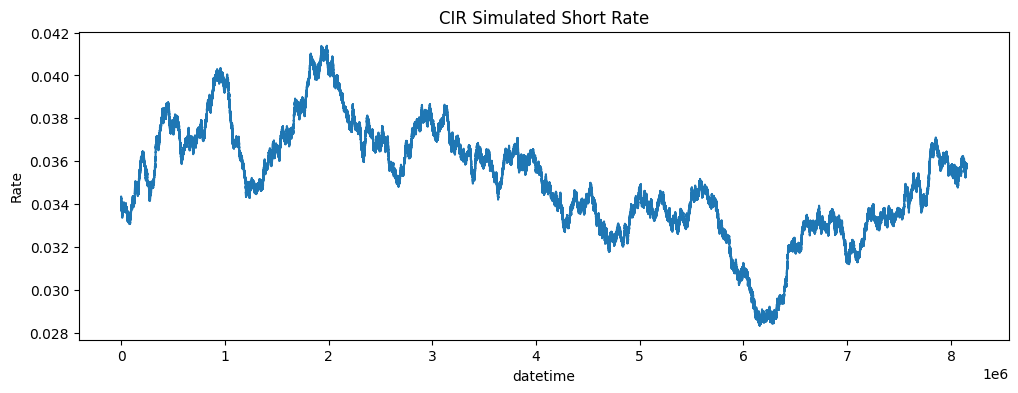

In [7]:

plot_df = rates_df  
plot_df['short_rate'].plot(figsize=(12,4), title='CIR Simulated Short Rate')
plt.ylabel('Rate')
plt.show()


In [8]:
rates_df['time_to_maturity'] = 10.0 - np.arange(len(rates_df)) * dt
rates_df['bond_price'] = rates_df.apply(
    lambda row: cir_bond_price(row['time_to_maturity'], a, b, sigma, row['short_rate']), axis=1
)


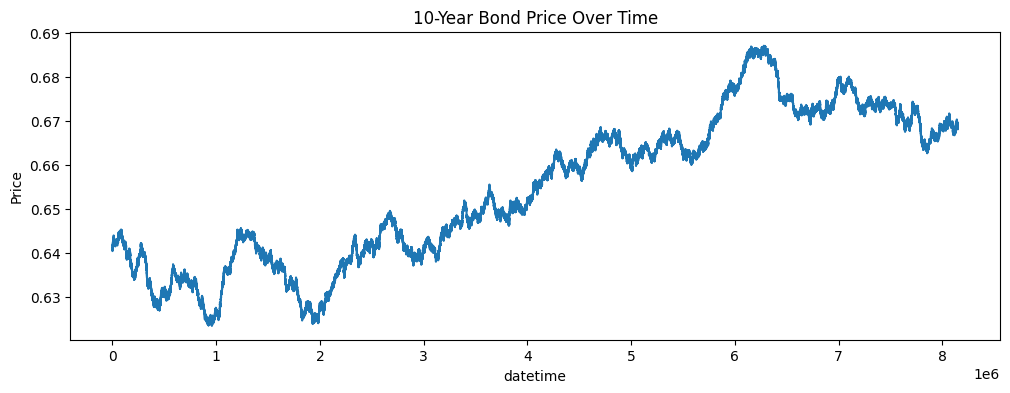

In [9]:
rates_df['bond_price'].plot(figsize=(12, 4), title='10-Year Bond Price Over Time')
plt.ylabel('Price')
plt.show()

In [ ]:
mid_prices = rates_df['bond_price'].values
spreads = np.random.uniform(0.001, 0.01, size=days * 539 * 60)
bid_prices = mid_prices - spreads / 2
ask_prices = mid_prices + spreads / 2

In [11]:
k_base = 60
k_values = np.random.normal(loc=k_base, scale=2, size=days*539*60)
k_values = np.clip(k_values, 30, 90)

In [12]:
max_trades_per_second = 2
lambda_bid = max_trades_per_second * np.exp(-k_values * (mid_prices - bid_prices))
lambda_ask = max_trades_per_second * np.exp(-k_values * (ask_prices - mid_prices))

vol_ask = np.random.poisson(lambda_ask)
vol_bid = np.random.poisson(lambda_bid)

In [13]:
market_df = pd.DataFrame({
    'time_index': time_index,
    'mid_price': mid_prices,
    'bid_price': bid_prices,
    'ask_price': ask_prices,
    'vol_bid': vol_bid,
    'vol_ask': vol_ask
})

In [ ]:
market_df.to_csv('Data/simulated_bond_market_data.csv', index=False)